# Importing Labraries

In [1]:
import pandas as pd
from unidecode import unidecode
import re
import locale
locale.setlocale(locale.LC_TIME, 'es_ES') # setting a local configuration for dates values

'es_ES'

# Functions

In this notebook we are going to build some functions to test the API.

In [2]:
df_movies = pd.read_csv("../processed_data/movies.csv")
df_cast = pd.read_csv("../processed_data/cast.csv")
df_crew = pd.read_csv("../processed_data/crew.csv")
actor_financial = pd.read_csv("../processed_data/actor_financial.csv")
director_financial = pd.read_csv("../processed_data/director_financial.csv")

## Amount of films by month

In [3]:
def cantidad_filmaciones_mes(month: str):
    if type(month) == str:
        month = month.lower().strip().replace(" ", "")
        month = unidecode(month)  # delete accents
        month = re.sub(r'[^\w\s]', '', month)  # delete special characters and punctuation marks
        # '%B' complete name of the month, strftime is string format time, it allows to format date data to a desirable representation
        # dt only works with pandas series that are datetime type
        df_movies["release_month"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%B')
        if month in df_movies["release_month"].unique():
            count_by_month = df_movies.groupby(["release_month"])["title"].count()
            return {month: count_by_month[month].item()} # needs item() because fastapi doesn't process numpy.int64 type objects 
        else:
            return "Entered value is not valid." # if we use print() instead of return, the output will be null
    else:
        return "Entered value is not valid." 


In [5]:
cantidad_filmaciones_mes("+ábril")

{'abril': 3809}

In [7]:
# other option to get a dictionary with the answer

count_by_month = df_movies.groupby(["release_month"])["title"].count().reset_index()
index = (count_by_month["release_month"] == "abril" ).idxmax()
count_by_month.loc[index, :].to_dict()
 

{'release_month': 'abril', 'title': 3809}

In [8]:
df_movies["release_month"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%B') 
count_by_month = df_movies.groupby(["release_month"])["title"].count()
count_by_month

release_month
abril         3809
agosto        3699
diciembre     4124
enero         6532
febrero       3305
julio         2894
junio         3487
marzo         3870
mayo          3691
noviembre     4018
octubre       5030
septiembre    5356
Name: title, dtype: int64

## Amount of films by day of the week.

In [9]:
def cantidad_filmaciones_dia(day: str):
    if type(day) == str:
        day = day.lower().strip().replace(" ", "")
        day = unidecode(day) # delete accents
        day = re.sub(r'[^\w\s]', '', day) # delete special characters and punctuation marks
        # dt only works with pandas series that are datetime type
        # '%A' complete name of the day, strftime is string format time, it allows to format date data to a desirable representation
        df_movies["release_day"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%A') 
        if day in df_movies["release_day"].unique():
            count_by_day = df_movies.groupby(["release_day"])["title"].count()
            return {day:count_by_day[day].item()}
        else:
            return "Entered value is not valid." 
    else:
        return "Entered value is not valid."
    

In [10]:
cantidad_filmaciones_dia("Viérnes-")

{'viernes': 15105}

In [11]:
df_movies["release_day"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%A') 
count_by_day = df_movies.groupby(["release_day"])["title"].count()
count_by_day 

release_day
domingo       4017
jueves        8291
lunes         3846
martes        5186
miércoles     7691
sábado        5679
viernes      15105
Name: title, dtype: int64

## Getting the popularity of a movie introducing the title.

There is a situation with the movies that have to be adressed here, there are duplicates for some movies because there are released in different languages. This function will get the popularity using idxmax() to get the index according to the title. idxmax() will consider only the first occurrence.

In [12]:
df_movies[df_movies["title"] == "12 Angry Men"]

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,...,spoken_languages_list,production_companies_list,production_countries_list,release_year,return,director,transformed_title,transformed_director,release_month,release_day
1232,350000.0,389,en,The defense and the prosecution have rested an...,16.503959,1957-03-25,1000000.0,96.0,Released,12 Angry Men,...,['en'],"['United Artists', 'Orion-Nova Productions']",['US'],1957,2.86,Sidney Lumet,12angrymen,sidneylumet,marzo,lunes
16406,0.0,12219,en,During the trial of a man accused of his fathe...,3.679263,1997-08-17,0.0,117.0,Released,12 Angry Men,...,"['en', 'hu', 'ru']",['MGM Television'],['US'],1997,0.00,William Friedkin,12angrymen,williamfriedkin,agosto,domingo


In [17]:
def score_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title) # delete accents
        title = re.sub(r'[^\w\s]', '', title) # delete special characters and punctuation marks
        if title in df_movies["transformed_title"].unique(): # there are repeated movies (different language)
            index = (df_movies["transformed_title"] == title).idxmax()
            return {
                    "Title":df_movies["title"][index], 
                    "Year":df_movies["release_year"][index].item(), 
                    "Popularity":df_movies["popularity"][index].round(2).item()
                    } 
        else:
            return "Entered value is not valid."
    else:
        return "Entered value is not valid."

In [18]:
score_titulo("12angry, MEN")

{'Title': '12 Angry Men', 'Year': 1957, 'Popularity': 16.5}

This function right here will group the title column and sum the popularity of every occurrence.

In [19]:
def score_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title)  # delete accents
        title = re.sub(r'[^\w\s]', '', title)  # delete special characters and punctuation marks      
        df_grouped = df_movies.groupby("transformed_title")["popularity"].sum()
        if title in df_grouped.index: # values of the grouped column are the new index in a grouped df
            normal_index = (df_movies["transformed_title"] == title).idxmax() # index for non transformed and non grouped values
            return {
                    "Title": df_movies["title"][normal_index], 
                    "Year": df_movies["release_year"][normal_index].item(), 
                    "Popularity" : df_grouped[title].round(2).item()
                    } 
        else:
            return "Entered value is not valid."
    else:
        return "Entered value is not valid."


In [20]:
score_titulo("12angry MEN")

{'Title': '12 Angry Men', 'Year': 1957, 'Popularity': 20.18}

## Getting total votes and average vote of a movie.

Here we have to deal with same situation of the previous function. This is the solution usig idxmax().

In [21]:
def votos_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title) # delete accents
        title = re.sub(r'[^\w\s]', '', title) # delete special characters and punctuation marks
        if title in df_movies["transformed_title"].unique(): # there are repeated movies (different language) 
            index = (df_movies["transformed_title"] == title).idxmax()
            if df_movies["vote_count"][index] >= 2000:
                return {
                        "Title": df_movies["title"][index], 
                        "Year": df_movies["release_year"][index].item(), 
                        "Total votes": df_movies["vote_count"][index].item(), 
                        "Average vote": df_movies["vote_average"][index].item()
                        }
            else:
                return "Movie must have at least 2000 votes"
        else:
            return "Entered value is not valid."
    else:
        return "Entered value is not valid."

In [22]:
votos_titulo("12anGRY mén ")

{'Title': '12 Angry Men',
 'Year': 1957,
 'Total votes': 2130.0,
 'Average vote': 8.2}

In [23]:
votos_titulo("moonlight")

'Movie must have at least 2000 votes'

In [24]:
df_movies[df_movies["title"] == "Moonlight"] # checking the vote_count

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,...,spoken_languages_list,production_companies_list,production_countries_list,release_year,return,director,transformed_title,transformed_director,release_month,release_day
43744,4000000.0,376867,en,"The tender, heartbreaking story of a young man...",14.171675,2016-10-21,65046687.0,111.0,Released,Moonlight,...,['en'],"['Plan B Entertainment', 'Upload Films', 'A24'...",['US'],2016,16.26,Barry Jenkins,moonlight,barryjenkins,octubre,viernes


And this is the solution considering all the occurrences and using aggregation functions.

In [25]:
def votos_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title)  # delete accents
        title = re.sub(r'[^\w\s]', '', title)  # delete special characters and punctuation marks
        df_grouped_total = df_movies.groupby("transformed_title")["vote_count"].sum()
        df_grouped_average = df_movies.groupby("transformed_title")["vote_average"].mean()
        if title in df_grouped_average.index: # values of the grouped column are the new index in a grouped df
             if df_grouped_total[title] >= 2000:
                normal_index = (df_movies["transformed_title"] == title).idxmax() # index for non transformed and non grouped values
                return {
                        "Title": df_movies["title"][normal_index], 
                        "Year": df_movies["release_year"][normal_index].item(), 
                        "Total Votes" : df_grouped_total[title].item(), 
                        "Average Vote" : df_grouped_average[title].item()
                        }
             else:
                 return "Movie must have at least 2000 votes"
        else:
            return "Entered value is not valid."    
    else:
        return "Entered value is not valid."

In [26]:
votos_titulo("moonlight")

'Movie must have at least 2000 votes'

In [27]:
votos_titulo("12 angry, men")

{'Title': '12 Angry Men',
 'Year': 1957,
 'Total Votes': 2189.0,
 'Average Vote': 7.85}

## Getting return and number of movies of an actor.

In [32]:
def get_actor(name):
    if type(name) == str:
        name = name.lower().strip().replace(" ", "")
        name = unidecode(name)  # delete accents
        name = re.sub(r'[^\w\s]', '', name)  # delete special characters and punctuation marks
        if name in actor_financial["transformed_name"].unique():
            index = (actor_financial["transformed_name"] == name).idxmax()
            return {
                    'actor':actor_financial["name"][index], 
                    'films':actor_financial["films"][index].item(), 
                    'total_return':actor_financial["total_return"][index].round(2).item(), 
                    'average_return':actor_financial["average_return"][index].item()
                    }        
        else:
            return "Entered value is not valid."
    return "Entered value is not valid."
   

In [33]:
get_actor("Johnnydépp")

{'actor': 'Johnny Depp',
 'films': 74,
 'total_return': 2.83,
 'average_return': 2.07}

## Getting return of a director and information about them movies.

In [34]:
def get_director(name):
    if type(name) == str:
        name = name.lower().strip().replace(" ", "")
        name = unidecode(name)  # delete accents
        name = re.sub(r'[^\w\s]', '', name)  # delete special characters and punctuation marks
        if name in director_financial["transformed_name"].unique():
            index = (director_financial["transformed_name"] == name).idxmax()
            movies_director = df_movies[df_movies["transformed_director"] == name]
            movies_director = movies_director[["title","release_year", "return", "budget", "revenue"]]
            return {
                        'director':director_financial["name"][index], 
                        'total return':director_financial["total_return"][index].round(2).item(), 
                        'films': movies_director.to_dict(orient='records')
                     }
        else:
            return "Entered value is not valid."
    return "Entered value is not valid."

In [35]:
get_director("Ste venSpielberg.. ")

{'director': 'Steven Spielberg',
 'total return': 5.29,
 'films': [{'title': 'Jurassic Park',
   'release_year': 1993,
   'return': 14.6,
   'budget': 63000000.0,
   'revenue': 920100000.0},
  {'title': "Schindler's List",
   'release_year': 1993,
   'return': 14.61,
   'budget': 22000000.0,
   'revenue': 321365567.0},
  {'title': 'E.T. the Extra-Terrestrial',
   'release_year': 1982,
   'return': 75.52,
   'budget': 10500000.0,
   'revenue': 792965326.0},
  {'title': 'Raiders of the Lost Ark',
   'release_year': 1981,
   'return': 21.66,
   'budget': 18000000.0,
   'revenue': 389925971.0},
  {'title': 'Indiana Jones and the Last Crusade',
   'release_year': 1989,
   'return': 9.88,
   'budget': 48000000.0,
   'revenue': 474171806.0},
  {'title': 'Jaws',
   'release_year': 1975,
   'return': 67.24,
   'budget': 7000000.0,
   'revenue': 470654000.0},
  {'title': 'The Lost World: Jurassic Park',
   'release_year': 1997,
   'return': 3.14,
   'budget': 73000000.0,
   'revenue': 229074524.

# EDA PARA EL 1.

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

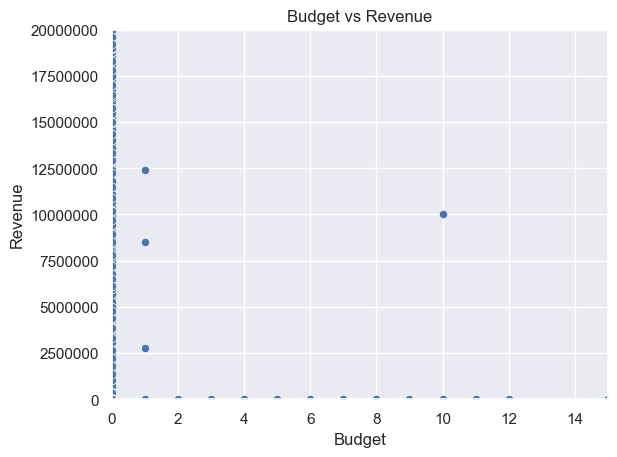

In [120]:
sns.set(context="notebook")
sns.scatterplot(df_movies, x="budget", y="revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title("Budget vs Revenue")
plt.xlim(0,15)
plt.ylim(0, 20000000)
plt.ticklabel_format(style='plain', axis='both')
